We will use a customer churning dataset and build a classifier for that. The data set is obtained from Kaggle here
https://www.kaggle.com/blastchar/telco-customer-churn. The goal is to predict whether a customer will churn (i.e. leave) given a set of predictors. This assignment will require you to use KNN and cross validation to build a predictive model.

In [1]:
# Here are just the usual libraries. You may need to load other libraries later yourself

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore') 

In [2]:
data = pd.read_csv('churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Clean up data and create dummy variables
1) Remove the following columns: customerID, OnlineSecurity, OnlineBackup, DeviceProtection, StreamingMovies, PaperlessBilling and PaymentMethod. 

2) Create dummy variables for the rest of the categorical variables (except for Churn, which is your output variable). Remove the corresponding categorical variables from the dataset afterwards.

3) You should have a total of 19 columns after these preprocessing steps (including the response variable).

In [3]:
# Remove columns

data1=data.drop(['customerID', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingMovies', 
                 'PaperlessBilling', 'PaymentMethod'],axis = 1)
data1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,TechSupport,StreamingTV,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,No,No,One year,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,Month-to-month,70.70,151.65,Yes


In [4]:
# Create dummy variables

GenderDummy = pd.get_dummies(data1.gender, prefix = 'Gender')
del GenderDummy['Gender_Male']

#there is no need to change on SeniorCitizen since it is already 0/1   

PartnerDummy = pd.get_dummies(data1.Partner, prefix = 'Partner')
del PartnerDummy['Partner_No']
                              
DependentsDummy = pd.get_dummies(data1.Dependents, prefix = 'Dependents')
del DependentsDummy['Dependents_No']

#there is no need tp change tenure

PhoneServiceDummy = pd.get_dummies(data1.PhoneService, prefix = 'PhoneService')
del PhoneServiceDummy['PhoneService_No']

MultipleLinesDummy = pd.get_dummies(data1.MultipleLines, prefix = 'MultipleLines')
del MultipleLinesDummy['MultipleLines_No']

InternetServiceDummy = pd.get_dummies(data1.InternetService, prefix = 'InternetService')
del InternetServiceDummy['InternetService_Fiber optic']

TechSupportDummy = pd.get_dummies(data1.TechSupport, prefix = 'TechSupport')
del TechSupportDummy['TechSupport_No']

StreamingTVDummy = pd.get_dummies(data1.StreamingTV, prefix = 'StreamingTV')
del StreamingTVDummy['StreamingTV_No']

ContractDummy = pd.get_dummies(data1.Contract, prefix = 'Contract')
del ContractDummy['Contract_Month-to-month']

#there is no need to change MonthlyCharges and TotalCharges

data1 = pd.concat([data1, GenderDummy, PartnerDummy, DependentsDummy, PhoneServiceDummy, 
                   MultipleLinesDummy, InternetServiceDummy, TechSupportDummy, 
                  StreamingTVDummy, ContractDummy], 
                        axis=1)

# Delete unnecessary columns
del data1['gender']
del data1['Partner']
del data1['Dependents']
del data1['PhoneService']
del data1['MultipleLines']
del data1['InternetService']
del data1['TechSupport']
del data1['StreamingTV']
del data1['Contract']

data1.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,Gender_Female,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,Contract_One year,Contract_Two year
0,0,1,29.85,29.85,No,1,1,0,0,1,0,1,0,0,0,0,0,0,0
1,0,34,56.95,1889.50,No,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,0,2,53.85,108.15,Yes,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,0,45,42.30,1840.75,No,0,0,0,0,1,0,1,0,0,1,0,0,1,0
4,0,2,70.70,151.65,Yes,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [5]:
data1.shape

(7032, 19)

In [6]:
# Separate the X and Y

X = data1.copy() 
del X['Churn']
y = data1['Churn']

### KNN + Cross Validation
Your task is to build a KNN model, where you will use CV to select the best K value and other arguments. You are to do this using two methods: the long way, where you will write a couple for loops, and the short way, by using GridSearchCV.

#### The long way
First write a CV with the long way. Remember the procedure: 

1) Split data to get a holdout set (use test size of 30% and random_state 1).

2) Define candidate parameters.

3) For each pair of candidate parametesr, conduct a CV (use 5 folds) on the training set.

4) Obtain the best pair of candidate parameter.

5) Refit the model with the entire training set. Perform evaluation on the holdout set to get an unbiased evaluation of the performance.

In [7]:
# Split data into training and holdout set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [8]:
# Set up candidate values
# We will select the best K, as well as the order for the minkowski metric in the KNeighborsClassifier function

k_values = range(1, 21) # Number of neighbors
p = [1,2,3,4] # Power parameter for the Minkowski metric. See KNeighborsClassifer description for more details

# Now we will form all pairs of k_values and p. 
# We have 20 choices for k and 4 choices for p, so we will have 80 pairs in total.
# We will use the itertools library to help us form all combination pairs
import itertools

hyperparameter_pairs = list(itertools.product(k_values, p)) 
print(hyperparameter_pairs)

[(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4), (5, 1), (5, 2), (5, 3), (5, 4), (6, 1), (6, 2), (6, 3), (6, 4), (7, 1), (7, 2), (7, 3), (7, 4), (8, 1), (8, 2), (8, 3), (8, 4), (9, 1), (9, 2), (9, 3), (9, 4), (10, 1), (10, 2), (10, 3), (10, 4), (11, 1), (11, 2), (11, 3), (11, 4), (12, 1), (12, 2), (12, 3), (12, 4), (13, 1), (13, 2), (13, 3), (13, 4), (14, 1), (14, 2), (14, 3), (14, 4), (15, 1), (15, 2), (15, 3), (15, 4), (16, 1), (16, 2), (16, 3), (16, 4), (17, 1), (17, 2), (17, 3), (17, 4), (18, 1), (18, 2), (18, 3), (18, 4), (19, 1), (19, 2), (19, 3), (19, 4), (20, 1), (20, 2), (20, 3), (20, 4)]


In [9]:
# Conduct CV. Use accuracy rate as the evaluation metrics. (It will take a couple minutes to run)

from sklearn.model_selection import KFold

#First we need to define the K folds

#kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

validation_acc = [] # Store the validation results
for ind, pairs in enumerate(hyperparameter_pairs):
    # Complete the rest
    kfold = KFold(5, True, ind) # We will not fix a random_state here so each lambda we get a different train/validation set 
    tmp_acc = [] # To store the current hyperparameter's validation MSE
    for train_index, valid_index in kfold.split(X_train):
        X_training, Y_training = X_train.iloc[train_index], y_train.iloc[train_index] # Training set
        X_validation, Y_validation = X_train.iloc[valid_index], y_train.iloc[valid_index]
    
        #Scale the data
        scaler = StandardScaler().fit(X_training)
        X_training = scaler.transform(X_training)
        X_validation = scaler.transform(X_validation)
        
        #perform KNN
        knn = KNeighborsClassifier(n_neighbors = pairs[0], weights= 'uniform', p = pairs[1])
        knn.fit(X_training, Y_training)
        #y_hat = knn.predict(X_validation)
        #tmp_acc.append(sum(y_hat == Y_validation)/len(Y_validation))
        tmp_acc.append(knn.score(X_validation, Y_validation))
        
            
    validation_acc.append(np.mean(tmp_acc)) # Calculate the average MSE across the K folds

print(validation_acc)

[0.7255179315752549, 0.7159723082002394, 0.7206390574058025, 0.7163740662787339, 0.7637140439932317, 0.7616802855845817, 0.7606698031447319, 0.7602626800379679, 0.7659508480871612, 0.762700466344765, 0.7655439313276381, 0.7622943749742066, 0.7754993603235525, 0.7742767529198135, 0.7801677603070447, 0.7704195039412324, 0.7771251702364739, 0.7677764021295036, 0.766967520944245, 0.7665535883785235, 0.777328215921753, 0.7763136065370805, 0.7791562461309891, 0.7761091164211136, 0.7797608435475218, 0.7734637447897322, 0.7720420122982956, 0.7718406173909456, 0.7752989971524082, 0.7815954768684742, 0.7746849077627832, 0.7754991539763114, 0.777735132681276, 0.7801702364739383, 0.7750893483554125, 0.7773263587965829, 0.7801714745573852, 0.7791519128389254, 0.773870455202014, 0.784840906277083, 0.7803714250340474, 0.776719697907639, 0.7763144319260451, 0.775704263134002, 0.7872809624035326, 0.7736665841277702, 0.7740716437621229, 0.7712314803351079, 0.7819980603359332, 0.774077834179357, 0.778951

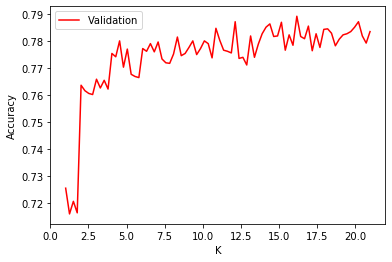

In [10]:
# Let's plot the averaged MSE

pairs_scale = np.linspace(1, 21, 80)
plt.plot(pairs_scale, validation_acc, color = 'red', label = 'Validation')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [11]:
# Find the best hyperparameter pair

bestPair = np.argmax(validation_acc)
hyperparameter_pairs[bestPair]

#best_hyperparameter_pair = hyperparameter_pairs[np.argmax(validation_acc)]
#print (best_hyperparameter_pair)
#print (np.max(validation_acc))

(16, 1)

In [12]:
print (np.max(validation_acc))

0.7893124509925303


In [13]:
# Refit using the whole training set and evaluation

scaler = StandardScaler().fit(X_train)
X_trainS = pd.DataFrame(scaler.transform(X_train))
X_testS = pd.DataFrame(scaler.transform(X_test))
X_trainS.columns = X.columns.values

# Model fitting

knn = KNeighborsClassifier(n_neighbors = hyperparameter_pairs[bestPair][0], 
                          p = hyperparameter_pairs[bestPair][1])
knn.fit(X_trainS, y_train)
yhat = knn.predict(X_testS)
np.mean(yhat == y_test) # Accuracy on test set

0.7758293838862559

#### The short(er) way
Now repeat the above procedure, but using GridSearchCV, along with Pipeline. Again use 5 folds. Becareful of the scoring function to use.

In [14]:
# Set up the Pipeline and GridSearchCV. Fit the model.
# (It will take a few minutes to run if you are not using n_jobs = -1)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time

start = time.time()

# Set up the model pipeline
estimator = Pipeline(steps = [('scale', StandardScaler()), # We first need to scale the data
                     ('knn', KNeighborsClassifier()) ]) # Then fit the scaled data using KNN

# Set up the parameters for each item in the pipeline
# Parameters of pipelines can be set using ‘__’ separating the parameter names:
parameters = {'knn__n_neighbors': range(1, 21),
             'knn__p': [1,2,3,4]} # Here is a second argument for KNN, just to illustrate how to add
                                          # multiple hyperparameters to tune.

model = GridSearchCV(estimator = estimator, param_grid = parameters, cv = 5, 
                   scoring = 'accuracy', n_jobs = -1) # Instantiate the gridsearch
model.fit(X_train, y_train) # Fit the grid search, i.e. perform CV and grid search. 

# Best neighborhood size (k)
print(model.best_params_ )

end = time.time()
print(end-start)

{'knn__n_neighbors': 16, 'knn__p': 1}
22.68073844909668


In [15]:
# Perform evaluation on the test set. Report the final accuracy score.
#model.fit(X_test, y_test)
#yhat = model.predict(X_test)
#np.mean(yhat == y_test) # Accuracy on test set

from sklearn import metrics
model.predict(X_test)
metrics.accuracy_score(model.predict(X_test),y_test)

0.7758293838862559

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html